In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [367]:
import cirq
from mitiq import zne, benchmarks
from mitiq.benchmarks import random_circuits
import math
import numpy as np
from functools import partial
import re 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from mitiq import cdr, Observable, PauliString

from mitiq import pec
from mitiq.pec import NoisyOperation, OperationRepresentation
from mitiq.pec.representations.depolarizing import local_depolarizing_kraus
from mitiq.pec.channels import kraus_to_super
from mitiq.utils import _circuit_to_choi

In [368]:
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory

# method: scale noise by 1 and 2, then extrapolate linearly to the zero noise limit.
linear_fac = LinearFactory(scale_factors=[1.0, 2.0])

# method: scale noise by 1, 2 and 3, then evaluate the Richardson extrapolation.
scale_factors = [1.0, 3.0, 5.0, 7.0] #[1.0, 2.0, 3.0]
richardson_fac = RichardsonFactory(scale_factors=scale_factors)

# method: scale noise by 1, 2, 3, and 4, then extrapolate quadratically to the zero noise limit.
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0, 4.0], order=2)

my_fac = richardson_fac

In [369]:
rng = np.random.default_rng()
def random_compile(mycircuit, nqubits, qreg, isTarget, type):
    def apply_cnot(mycircuit, operation = cirq.ops.gate_operation):
    
        myList =  [float(s) for s in re.findall(r'[-+]?\d*\.\d+|\d+', str(operation))] #r'\b\d+\b'
        phase = 0
        if len(myList) == 2:
            b0, b1 = int(myList[0]), int(myList[1])
        elif len(myList) == 3:
            phase, b0, b1 = myList[0], int(myList[1]), int(myList[2])
        
        if type == 0:
            mycircuit.append(operation)
        elif type == 1:
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.X(qreg[b1]))
        elif type == 2:
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Z(qreg[b0]))     
            mycircuit.append(cirq.Y(qreg[b1]))
        elif type == 3:
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Z(qreg[b0]))     
            mycircuit.append(cirq.Z(qreg[b1]))            
        elif type == 4:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b0]))     
            mycircuit.append(cirq.X(qreg[b1]))            
        elif type == 5:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)   
            mycircuit.append(cirq.Y(qreg[b0]))            
        elif type == 6:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation) 
            mycircuit.append(cirq.X(qreg[b0])) 
            mycircuit.append(cirq.Z(qreg[b1]))       
        elif type == 7:
            mycircuit.append(cirq.Y(qreg[b0]))
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)  
            mycircuit.append(cirq.X(qreg[b0])) 
            mycircuit.append(cirq.Y(qreg[b1]))               
        elif type == 8:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(operation)  
            mycircuit.append(cirq.X(qreg[b0])) 
            mycircuit.append(cirq.X(qreg[b1]))               
        elif type == 9:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)   
            mycircuit.append(cirq.X(qreg[b0]))              
        elif type == 10:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b0])) 
            mycircuit.append(cirq.Z(qreg[b1]))             
        elif type == 11:
            mycircuit.append(cirq.X(qreg[b0]))
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b0])) 
            mycircuit.append(cirq.Y(qreg[b1]))             
        elif type == 12:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(operation) 
            mycircuit.append(cirq.Z(qreg[b0]))           
        elif type == 13:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(cirq.X(qreg[b1]))
            mycircuit.append(operation)   
            mycircuit.append(cirq.Z(qreg[b0])) 
            mycircuit.append(cirq.X(qreg[b1]))             
        elif type == 14:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(cirq.Y(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Y(qreg[b1]))             
        elif type == 15:
            mycircuit.append(cirq.Z(qreg[b0]))
            mycircuit.append(cirq.Z(qreg[b1]))
            mycircuit.append(operation)
            mycircuit.append(cirq.Z(qreg[b1]))             
        return mycircuit   
    
    mycircuit2 = cirq.Circuit() 
    
    for moment in mycircuit:
        myTuple = moment.operations
        for i in myTuple:
            if(isTarget == True):
                    mycircuit2.append(i)
            else:
                matchers = ['CXPowGate', 'CZ', 'CY', 'CX', 'CNOT']
                matching = bool([s for s in matchers if(s in str(i))])
                if matching == True:
                    #print("CNOT", print("i", type(i), i.gate)
                    mycircuit2 = apply_cnot(mycircuit2, i)
            
    #return cirq.ConvertToCzAndSingleGates().optimize_circuit(mycircuit2)        
    return mycircuit2 
    #return simplify(mycircuit2)
    
def fold(scale_factor, mycircuit):
    max_scale = math.ceil((scale_factor - 1)/2)*2 + 1
    p = 1 - (max_scale - scale_factor)/3
    mycircuit2 = cirq.Circuit() 

    for moment in mycircuit:
        myTuple = moment.operations
        for i in myTuple:
            matchers = ['CXPowGate', 'CZ', 'CY', 'CX', 'CNOT']
            matching = bool([s for s in matchers if(s in str(i))])
            if matching == True:
                #scale = rng.choice([max_scale,max_scale-2],p=[p,1-p])
                scale = scale_factor
                for _ in range(scale):
                    mycircuit2.append(i) 
            else:
                mycircuit2.append(i)
    return mycircuit2 


# def fold_and_compile(scale_factor, mycircuit, rand_compile, nqubits, qreg):
#     type = rng.integers(16)
#     mycircuit_fold = fold(scale_factor, mycircuit)
#     mycircuit_rand = random_compile(mycircuit, nqubits, qreg, type)
#     mycircuit_rand_fold = fold(scale_factor, mycircuit_rand)
#     #print("target_circuit\n", mycircuit, "\n")  
#     #print("target_circuit_fold\n", mycircuit_fold, "\n")
#     #print("estimation_circuit\n", mycircuit_rand, "\n")
#     #print("estimation_circuit_fold\n", mycircuit_rand_fold, "\n")
#     return mycircuit_rand, mycircuit_rand_fold


In [370]:
#Observable
from typing import Tuple
from mitiq import Executor, Observable, PauliString, MeasurementResult
from mitiq.interface import mitiq_cirq
from cirq import X, I

t = 7
paulis = []
paulis.append(PauliString("I", coeff=0.5*(2**t-1)))
for p in range(t):    
    paulis.append(PauliString("Z", coeff=0.5*-2**(t-1-p), support=(p,)))
obs = Observable(*paulis)
print("Obs:",obs)

#obs = Observable(PauliString("ZZ"), PauliString("X", coeff=-1.75))

Obs: (63.5+0j)*I + (-32+0j)*Z(0) + (-16+0j)*Z(1) + (-8+0j)*Z(2) + (-4+0j)*Z(3) + (-2+0j)*Z(4) + -Z(5) + (-0.5+0j)*Z(6)


In [375]:
import cirq
from mitiq import zne, benchmarks
from mitiq.benchmarks import random_circuits
import math
from mitiq import pec
from mitiq.pec import *
from mitiq.pec.pec import *
from mitiq.pec.representations import *

def execute(circuit: cirq.Circuit, noise_model: cirq.NoiseModel, noise_level: float = 0.001) -> float:
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
    #noisy_circuit = circuit.with_noise(noise_model = noise_model, p=my_noise_level)

    nm = cirq.NoiseModel.from_noise_model_like(noise_model(noise_level))
    
    noisy_circuit = circuit.with_noise(nm)
    return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real

def simulate(circuit: cirq.Circuit, noise_level: float = 0.001) -> float:
    """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
    noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
    return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real

def noisy_execute(circuit: cirq.Circuit, noise_level: float = my_noise_level) -> float:
   # """Returns Tr[ρ |0⟩⟨0|] where ρ is the state prepared by the circuit with depolarizing noise."""
        noisy_circuit = circuit.with_noise(cirq.depolarize(p=noise_level))
        return cirq.DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real

def ideal_executor(circuit: cirq.Circuit) -> float:
    return noisy_execute(circuit, noise_level=0)


#circuit: cirq.Circuit = benchmarks.generate_rb_circuits(n_qubits=1, num_cliffords=50)[0]

a, b = cirq.LineQubit.range(2)
circuit = cirq.Circuit()

rep = 3 #To make the circuit longer
for i in range(rep):
    circuit.append(cirq.rx(0.1).on(a))
    circuit.append(cirq.rx(-0.72).on(b))
    circuit.append(cirq.rz(0.4).on(a))
    circuit.append(cirq.rz(0.2).on(b))
    circuit.append(cirq.CNOT.on(a, b))
    circuit.append(cirq.rx(-0.1).on(b))
    circuit.append(cirq.rz(-0.23).on(a))
    circuit.append(cirq.CNOT.on(b, a))
    circuit.append(cirq.rx(-0.112).on(a))
    

representations = representations.represent_operations_in_circuit_with_local_depolarizing_noise(circuit,
                noise_level=0.001,)    
    
true_value = ideal_executor( circuit)       # Ideal quantum computer.
noisy_value = noisy_execute(circuit)                 # Noisy quantum computer.
pec_value, pec_data = pec.execute_with_pec(circuit=circuit, executor=noisy_execute, representations=representations, 
        num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)


print(f"Error (w/o  Mitiq): %0.4f" %abs((true_value - noisy_value) / true_value))
print(f"Error (with Mitiq): %0.4f" %abs((true_value - pec_value) / true_value))
#print(circuit)

Error (w/o  Mitiq): 0.1705
Error (with Mitiq): 0.1720


In [376]:
def add_rx_to_target_circuit(mycircuit, nqubits, qreg, randomness):
    mycircuit2 = cirq.Circuit() 
    
    #if randomness == True:
        #list0 = [np.random.uniform(0, 1*math.pi) for _ in range(nqubits)] #2*math.pi
    #else:
        #list0 = [math.pi/2 for _ in range(nqubits)] #math.pi/2
        
    list0 = [math.pi/6 for _ in range(nqubits)]
    
    for i in range(nqubits):
            mycircuit2.append(cirq.rx(list0[i]).on(qreg[i]))
            
    for moment in mycircuit:
        myTuple = moment.operations
        for i in myTuple:
                mycircuit2.append(i)
                
    for i in range(nqubits):
            mycircuit2.append(cirq.rx(-list0[i]).on(qreg[i]))
            
    return mycircuit2

In [377]:
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp

from mitiq import pec
from mitiq.pec import *
from mitiq.pec.pec import *
from mitiq.pec.representations import *

shots = 1024
def doSimulation (nTrials, my_noise_level, original_circuit, target_circuit, estimation_circuit, doZNE, doCDR, doPEC, nm):


    
    representations1 = representations.represent_operations_in_circuit_with_local_depolarizing_noise(target_circuit,
                noise_level=0.001,)
    representations2 = representations.represent_operations_in_circuit_with_local_depolarizing_noise(estimation_circuit,
                noise_level=0.001,)      

    error1, error2, error3, error4, error2z, error4z, error2z0, error4z0, error30, error2p, error4p = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    for i in range(nTrials):
        #print(i)
        cirq.ConvertToCzAndSingleGates().optimize_circuit(original_circuit)
        cirq.ConvertToCzAndSingleGates().optimize_circuit(target_circuit)
        cirq.ConvertToCzAndSingleGates().optimize_circuit(estimation_circuit)
        
        cdr_value, zne_value, pec_value, zne_value_cor, zne_value_org, cdr_value_cor, cdr_value_org, pec_value_cor, pec_value_org = 0, 0, 0, 0, 0, 0, 0, 0, 0
        
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(my_noise_level,), shots=shots)   
        
        
        #true_value = obs.expectation(target_circuit, execute=simulate).real
        #noisy_value =  obs.expectation(target_circuit, execute=execute_noisy).real
        #noisy_value_est = obs.expectation(estimation_circuit, execute=execute_noisy).real # Noisy version with the estimation circuit. 
        true_value = execute(target_circuit, noise_model=nm, noise_level=0.0)       # Ideal quantum computer.
        noisy_value = execute(target_circuit, noise_model=nm, noise_level= my_noise_level)       # Noisy quantum computer.
        noisy_value_est = execute(estimation_circuit, noise_model=nm, noise_level = my_noise_level)  # Noisy version with the estimation circuit.
        noisy_value_cor = noisy_value / noisy_value_est  # Corrected 
        true_value_org = execute(original_circuit, noise_model=nm, noise_level=0.0)  
        noisy_value_org = execute(original_circuit, noise_model=nm, noise_level = my_noise_level)  # Noisy version with the estimation circuit.
       
        print("true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org", true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org)
        
        if(doZNE): #ZNE
            #zne_value = zne.execute_with_zne(target_circuit, partial(execute_with_noise, noise_level=my_noise_level),observable=obs, factory=my_fac).real  # Noisy quantum computer + Mitiq.
            #zne_value_est = zne.execute_with_zne(estimation_circuit, partial(execute_with_noise, noise_level=my_noise_level),observable=obs, factory=my_fac).real # ZNE version with the estimation circuit.
            zne_value = zne.execute_with_zne(target_circuit, partial(execute, noise_model=nm, noise_level=my_noise_level),observable=obs, factory=my_fac).real  # Noisy quantum computer + Mitiq.
            zne_value_est = zne.execute_with_zne(estimation_circuit, partial(execute, noise_model=nm, noise_level=my_noise_level),observable=obs, factory=my_fac).real # ZNE version with the estimation circuit.
            zne_value_cor = zne_value / zne_value_est # Corrected #true_value * 
            #_1_p = zne_value_est / noisy_value_est
            #zne_value_cor = zne_value / _1_p    
            zne_value_org = zne.execute_with_zne(original_circuit, partial(execute, noise_model=nm, noise_level=my_noise_level),observable=obs, factory=my_fac).real  # Noisy quantum computer + Mitiq.
            print("zne_value, zne_value_est, zne_value_cor, zne_value_org", zne_value, zne_value_est, zne_value_cor, zne_value_org)
        
        if(doCDR): #CDR
            #cdr_value = cdr.execute_with_cdr(target_circuit, partial(execute_with_noise, noise_level=my_noise_level),observable=obs,simulator=simulate,).real   # Noisy quantum computer + Mitiq.
            #cdr_value_est = cdr.execute_with_cdr(estimation_circuit, partial(execute_with_noise, noise_level=my_noise_level), observable=obs,simulator=simulate,).real # CDR version with the estimation circuit.
            cdr_value = cdr.execute_with_cdr(target_circuit, partial(execute, noise_model=nm, noise_level=my_noise_level),observable=obs,simulator=simulate,).real   # Noisy quantum computer + Mitiq.
            cdr_value_est = cdr.execute_with_cdr(estimation_circuit, partial(execute, noise_model=nm, noise_level=my_noise_level), observable=obs,simulator=simulate,).real # CDR version with the estimation circuit.
            cdr_value_cor = cdr_value / cdr_value_est # Corrected true_value *
            #_1_p = cdr_value_est / noisy_value_est
            #cdr_value_cor = cdr_value / _1_p  
            cdr_value_org = cdr.execute_with_cdr(original_circuit, partial(execute, noise_model=nm, noise_level=my_noise_level),observable=obs,simulator=simulate,).real   # Noisy quantum computer + Mitiq.
            print("cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org", cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org)
         
            
        if(doPEC): #PEC
            #pec_value, pec_data = pec.execute_with_pec(circuit=target_circuit, executor=execute_with_noise,     ##########doubt############
                #representations=representations1, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)  # Noisy quantum computer + Mitiq.        
            #pec_value_est, pec_data_est = pec.execute_with_pec( circuit=estimation_circuit, executor=execute_with_noise,     ##########doubt############
                #representations=representations2, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),) 
            pec_value, pec_data = pec.execute_with_pec(circuit=target_circuit, executor=partial(execute, noise_model=nm, noise_level=my_noise_level),     ##########doubt############
                representations=representations1, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)  # Noisy quantum computer + Mitiq.        
            pec_value_est, pec_data_est = pec.execute_with_pec( circuit=estimation_circuit, executor=partial(execute, noise_model=nm, noise_level=my_noise_level),     ##########doubt############
                representations=representations2, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)             
            pec_value_cor = pec_value / pec_value_est # Corrected
            #pec_value, pec_data = pec.execute_with_pec(circuit=target_circuit, executor=noisy_execute,     ##########doubt############
            #    representations=representations1, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)  # Noisy quantum computer + Mitiq.        
            #pec_value_est, pec_data_est = pec.execute_with_pec( circuit=estimation_circuit, executor=noisy_execute,     ##########doubt############
            #    representations=representations2, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)             
            pec_value_cor = pec_value / pec_value_est # Corrected
            #_1_p = pec_value_est / noisy_value_est
            #pec_value_cor = pec_value / _1_p       
            pec_value_org, pec_data = pec.execute_with_pec(circuit=original_circuit, executor=partial(execute, noise_model=nm, noise_level=my_noise_level),     ##########doubt############
                representations=representations1, num_samples = 50, full_output=True, random_state = np.random.RandomState(7),)  # Noisy quantum computer + Mitiq.        
        
            print("pec_value, pec_value_est, pec_value_cor, pec_value_org", pec_value, pec_value_est, pec_value_cor, pec_value_org)
       
        #print("true_value, noisy_value, zne_value_cor, cdr_value_cor, pec_value_cor: ", true_value, noisy_value, zne_value_cor, cdr_value_cor, pec_value_cor)
        
        
        error1 = error1 + 1/nTrials* abs((true_value_org - noisy_value_org) / true_value_org) #w/o unmitigated
        error2 = error2 + 1/nTrials* abs((true_value_org - cdr_value_org) / true_value_org) #with Mitiq CDR, w/o RC
        error3 = error3 + 1/nTrials* abs((true_value - noisy_value_cor) / true_value) #w/o Mitiq, with RC
        error4 = error4 + 1/nTrials* abs((true_value - cdr_value_cor) / true_value) #with both Mitiq CDR & RC  
        error2z = error2z + 1/nTrials* abs((true_value_org - zne_value_org) / true_value_org) #with Mitiq ZNE, w/o RC
        error4z = error4z + 1/nTrials* abs((true_value - zne_value_cor) / true_value) #with both Mitiq ZNE & RC 
        error2p = error2p + 1/nTrials* abs((true_value_org - pec_value_org) / true_value_org) #with Mitiq PEC, w/o RC
        error4p = error4p + 1/nTrials* abs((true_value - pec_value_cor) / true_value) #with both Mitiq PEC & RC 
        
    return error1, error2, error3, error4, error2z, error4z, error2p, error4p

In [378]:
myqubits = [a,b]
nqubits = len(myqubits)
nTrials = 10

doZNE, doCDR, doPEC = True, True, True
noise_models = [depolarize]#, phase_flip, bit_flip, phase_damp, amplitude_damp]

my_noise_level_array = [0.01 *i for i in range(0,11,1)] 

original_circuit = circuit
#cirq.ConvertToCzAndSingleGates().optimize_circuit(original_circuit)
target_circuit = add_rx_to_target_circuit(original_circuit, nqubits, myqubits, False)# circuit
#target_circuit = add_rx_to_target_circuit(random_compile(circuit2, nqubits, myqubits, True, type = rng.integers(16)), nqubits, myqubits, True)
estimation_circuit = add_rx_to_target_circuit(random_compile(original_circuit, nqubits, myqubits, False, type = rng.integers(16)), nqubits, myqubits, True)

all_error_values = {}
for nm in noise_models:
    errors_nm = []
    error1_array, error2_array, error3_array, error4_array, error2z_array, error4z_array, error2p_array, error4p_array = [], [], [], [], [], [], [], []
    for my_noise_level in my_noise_level_array:    
        print("\n", nm.__name__, my_noise_level)
        error1, error2, error3, error4, error2z, error4z, error2p, error4p = doSimulation (nTrials, my_noise_level, original_circuit, target_circuit, estimation_circuit, doZNE, doCDR, doPEC, nm)
        error1_array.append(error1)
        error2_array.append(error2)
        error3_array.append(error3)
        error4_array.append(error4)
        error2z_array.append(error2z)
        error4z_array.append(error4z)    
        error2p_array.append(error2p)
        error4p_array.append(error4p) 
    errors_nm.append(error1_array)
    errors_nm.append(error2_array)
    errors_nm.append(error3_array)
    errors_nm.append(error4_array)
    errors_nm.append(error2z_array)
    errors_nm.append(error4z_array)
    errors_nm.append(error2p_array)
    errors_nm.append(error4p_array)
    
    all_error_values[nm.__name__] = errors_nm



 depolarize 0.0
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.6220706 0.9999999 0.62207067 0.6384983
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.6220701821148393 0.9999999776482591 0.6220701960191912 0.6384973712265491
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6044793380142223 0.9660989682556433 0.6256909052554422 0.6215717449046326
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.611448642612451 0.9914414503180912 0.6167269306889234 0.6219794550068365
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.6220706 0.9999999 0.62207067 0.6384983
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.6220701821148393 0.9999999776482591 0.6220701960191912 0.6384973712265491
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6047251728283135 0.9660989682556433 0.6259453665706584 0.6215576001452654
pec_value, pec_value_est,

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.45842487 0.6555302 0.6993192 0.47432482
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.6001489441841836 0.9514121189713465 0.6307980865674239 0.6191819123923772
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6020739280642049 0.9028429388999939 0.6668645255151022 0.6213255669760998
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.4620401084349999 0.727525403806708 0.6350845015410027 0.5073638785413204
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.45842487 0.6555302 0.6993192 0.47432482
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.6001489441841836 0.9514121189713465 0.6307980865674239 0.6191819123923772
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6035648178363864 0.9028429388999939 0.6685158534570341 0.6194305574158295
pec_value, pec_value_est, pec_value_cor,

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.31388313 0.36730283 0.8545622 0.32345384
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.42576222307980005 0.5943932104855763 0.7162972516660867 0.4493555054068558
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6007942203344129 0.9223024249077441 0.6514069616530707 0.6133080708493811
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.32423858837615976 0.42513108061059307 0.7626790963165365 0.3525287853543881
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.31388313 0.36730283 0.8545622 0.32345384
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.42576222307980005 0.5943932104855763 0.7162972516660867 0.4493555054068558
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6058925325747142 0.9223024249077441 0.6569347712983844 0.6131547472514213
pec_value, pec_value_est, pec_val

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.28494984 0.3126917 0.9112805 0.2916255
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.3594198171049352 0.46348997671157055 0.7754640556738552 0.37902866955846515
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.5911371327926598 0.9149846434595991 0.6460623541806593 0.6107649960247734
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.2919047201881184 0.355893205621649 0.8202031271663082 0.3144882226276337
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.28494984 0.3126917 0.9112805 0.2916255
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.3594198171049352 0.46348997671157055 0.7754640556738552 0.37902866955846515
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.586302789370496 0.9149846434595991 0.6407788300726646 0.6082266014032385
pec_value, pec_value_est, pec_value_cor

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.26020795 0.26763767 0.9722396 0.26308754
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.2895584963262079 0.3271611267700787 0.8850638802503664 0.30023320950567733
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6062931852319142 0.9532724618911743 0.6360124827576616 0.5957784218836859
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.26023462431781513 0.28898018602106057 0.9005275686923723 0.2756058127874632
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.26020795 0.26763767 0.9722396 0.26308754
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.2895584963262079 0.3271611267700787 0.8850638802503664 0.30023320950567733
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.5925726370767723 0.9532724618911743 0.6216193803618135 0.5999106287654259
pec_value, pec_value_est, pec_val

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25544766 0.2592753 0.9852372 0.25725648
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.27337944880127896 0.29573821928352095 0.9243967501515018 0.28079113177955134
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6047825151209398 0.9317936301231695 0.6490519956022842 0.6039412211866448
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.25304752576096873 0.2739395108048351 0.9237350428841549 0.2663059162129504
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25544766 0.2592753 0.9852372 0.25725648
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.27337944880127896 0.29573821928352095 0.9243967501515018 0.28079113177955134
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.5987213846263781 0.9317936301231695 0.6425471963649676 0.6087283180393985
pec_value, pec_value_est, pec_va

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25151113 0.25251514 0.99602395 0.2521773
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.257969308644533 0.2657688073813916 0.9706530694338936 0.26129878871142875
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.5746771292551074 0.961364209651947 0.5977725439385391 0.6117545684086814
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.24620896233695064 0.2596615964775169 0.9481916682210221 0.25703213072294845
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25151113 0.25251514 0.99602395 0.2521773
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.257969308644533 0.2657688073813916 0.9706530694338936 0.26129878871142875
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6046440709678649 0.961364209651947 0.6289438122382054 0.5921192758145821
pec_value, pec_value_est, pec_value_c

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25078565 0.25129634 0.9979678 0.2511784
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.2545974384993314 0.25917294435203087 0.9823457426694794 0.256767649203539
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6006548406998462 0.9616662859916687 0.6245980018738537 0.5866596982959571
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.24471118253443563 0.2565268497878838 0.9539398419182309 0.2548814785016323
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25078565 0.25129634 0.9979678 0.2511784
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.2545974384993314 0.25917294435203087 0.9823457426694794 0.256767649203539
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.5693434077711359 0.9616662859916687 0.5920384400125143 0.589589660328059
pec_value, pec_value_est, pec_value_cor

true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25020638 0.25033602 0.99948215 0.25033578
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.25149458460509766 0.2530424650758506 0.9938829221004903 0.2523734886199236
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.45279456837030807 0.9644566178321838 0.4694815298048944 0.5923503895281357
pec_value, pec_value_est, pec_value_cor, pec_value_org 0.24332868458248755 0.25361553658786984 0.9594391883723645 0.252795085747018
true_value, true_value_org, noisy_value, noisy_value_est, noisy_value_cor, noisy_value_org 0.6220706 0.6384983 0.25020638 0.25033602 0.99948215 0.25033578
zne_value, zne_value_est, zne_value_cor, zne_value_org 0.25149458460509766 0.2530424650758506 0.9938829221004903 0.2523734886199236
cdr_value, cdr_value_est, cdr_value_cor, cdr_value_org 0.6009707812465308 0.9644566178321838 0.6231185209733302 0.6048625980125735
pec_value, pec_value_est, pec_v

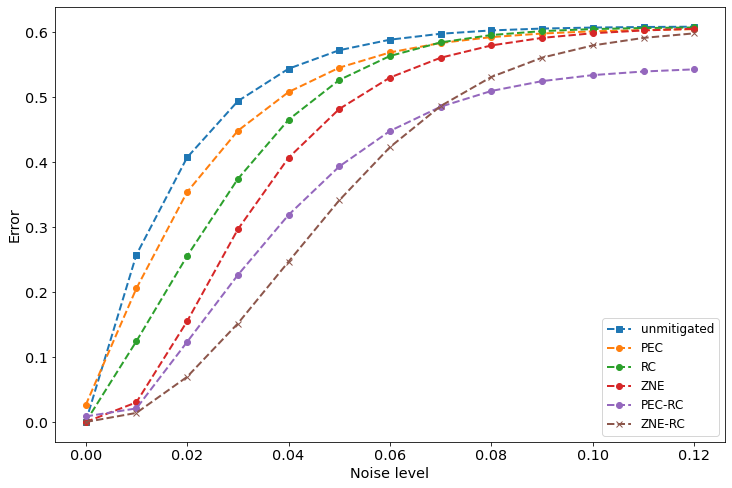

In [390]:
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth':2}
plt.rcParams.update(params)

plt.figure(figsize=(12, 8))

#range=-3 [:range]


my_noise_models = noise_models #noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
#my_noise_models = [depolarize, phase_flip]

for noise_model_index in range(len(my_noise_models)):

    noise_model_name = noise_models[noise_model_index].__name__
    error1_array, error2_array, error3_array, error4_array, error2z_array, error4z_array, error2p_array, error4p_array = all_error_values[noise_model_name]

    plt.plot(my_noise_level_array, error1_array, "--s", label="unmitigated, " + noise_model_name)
    plt.plot(my_noise_level_array, error3_array, "--o", label="only RC, " + noise_model_name)
    if(doZNE): #ZNE
        plt.plot(my_noise_level_array, error2z_array, "--o", label="ZNE, " + noise_model_name)
        plt.plot(my_noise_level_array, error4z_array, "--x", label="ZNE-RC, " + noise_model_name)
    if(doCDR): #CDR    
        plt.plot(my_noise_level_array, error2_array, "--o", label="CDR, " + noise_model_name)
        plt.plot(my_noise_level_array, error4_array, "--o", label="CDR-C, " + noise_model_name)
    if(doPEC): #PEC
        plt.plot(my_noise_level_array, error2p_array, "--o", label="PEC, " + noise_model_name)
        plt.plot(my_noise_level_array, error4p_array, "--o", label="PEC-RC, " + noise_model_name)    

    
#plt.plot(my_noise_level_array, error1_array, "--s", label="unmitigated") 
#plt.plot(my_noise_level_array, error2p_array, "--o", label="PEC")
#plt.plot(my_noise_level_array, error3_array, "--o", label="RC")    
#plt.plot(my_noise_level_array, error2z_array, "--o", label="ZNE")
#plt.plot(my_noise_level_array, error4p_array, "--o", label="PEC-RC" )    
#plt.plot(my_noise_level_array, error4z_array, "--x", label="ZNE-RC")  

plt.xlabel("Noise level")
plt.ylabel("Error")
#plt.title("Noise model: " + noise_models[noise_model_index].__name__)
#plt.title("Noise model: " + noise_models[noise_model_index1].__name__ + " vs " + noise_models[noise_model_index2].__name__)

plt.legend()
plt.legend(loc=4, prop={'size': 12})
#plt.savefig('zne_rc2.png', dpi=300, facecolor='white')
#plt.savefig('H:\QuantumComm\QISKIT\QCourse511\Proje\MITIQ\mitiq-master\docs\jupyter_execute\examples\zne_pec_rc_dep.png', dpi=300, facecolor='white')
plt.show();

In [261]:
#def extract_noise_results(all_error_values = {}):
    #noise_models = all_error_values.keys()
    #for nm in noise_models: 
        #print(all_error_values[nm])
    
#extract_noise_results (all_error_values)

In [262]:
#print(target_circuit,"------\n")
#print(estimation_circuit)

3
